In [108]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet, LassoLars
from sklearn.svm import SVR

from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

from supervised.automl import AutoML

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt # seaborn figure 크기 조절을 위해서
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
# 운영체제별 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 2
np.random.seed(SEED)

# 건물유형별 에너지소비 예측성능 향상을 위한 변수중요도 및 기계학습모델 평가 p.6 CVRMSE
def cvrmse_score(y_true, y_pred):
    return ((np.sqrt(mean_squared_error(y_true, y_pred))) / y_true.mean() ) * 100 

In [109]:
train_df = pd.read_csv('data/train_dv_df.csv', index_col=0)
test_df = pd.read_csv('data/test_dv_df.csv', index_col=0)
train_df.useDate = pd.to_datetime(train_df.useDate)
train_df.date = pd.to_datetime(train_df.date)
test_df.useDate = pd.to_datetime(test_df.useDate)
test_df.date = pd.to_datetime(test_df.date)

FileNotFoundError: [Errno 2] No such file or directory: 'data/train_dv_df.csv'

In [ ]:
train_df.columns

Index(['useDate', 'useType', 'toeQty', 'date', 'month', 'day', 'hour',
       'weekday', 'holiday', 'temp', 'rain', 'wind', 'hum', 'ss', 'sr',
       'operating', 'ft', 'THI', 'WCT', 'CDH24', 'day_hour_mean',
       'day_hour_std', 'hour_mean', 'hour_std'],
      dtype='object')

# ML

## DV_Y

In [ ]:
DV = 'Y'

In [ ]:
Operating_yn = 'N'

* 상관계수

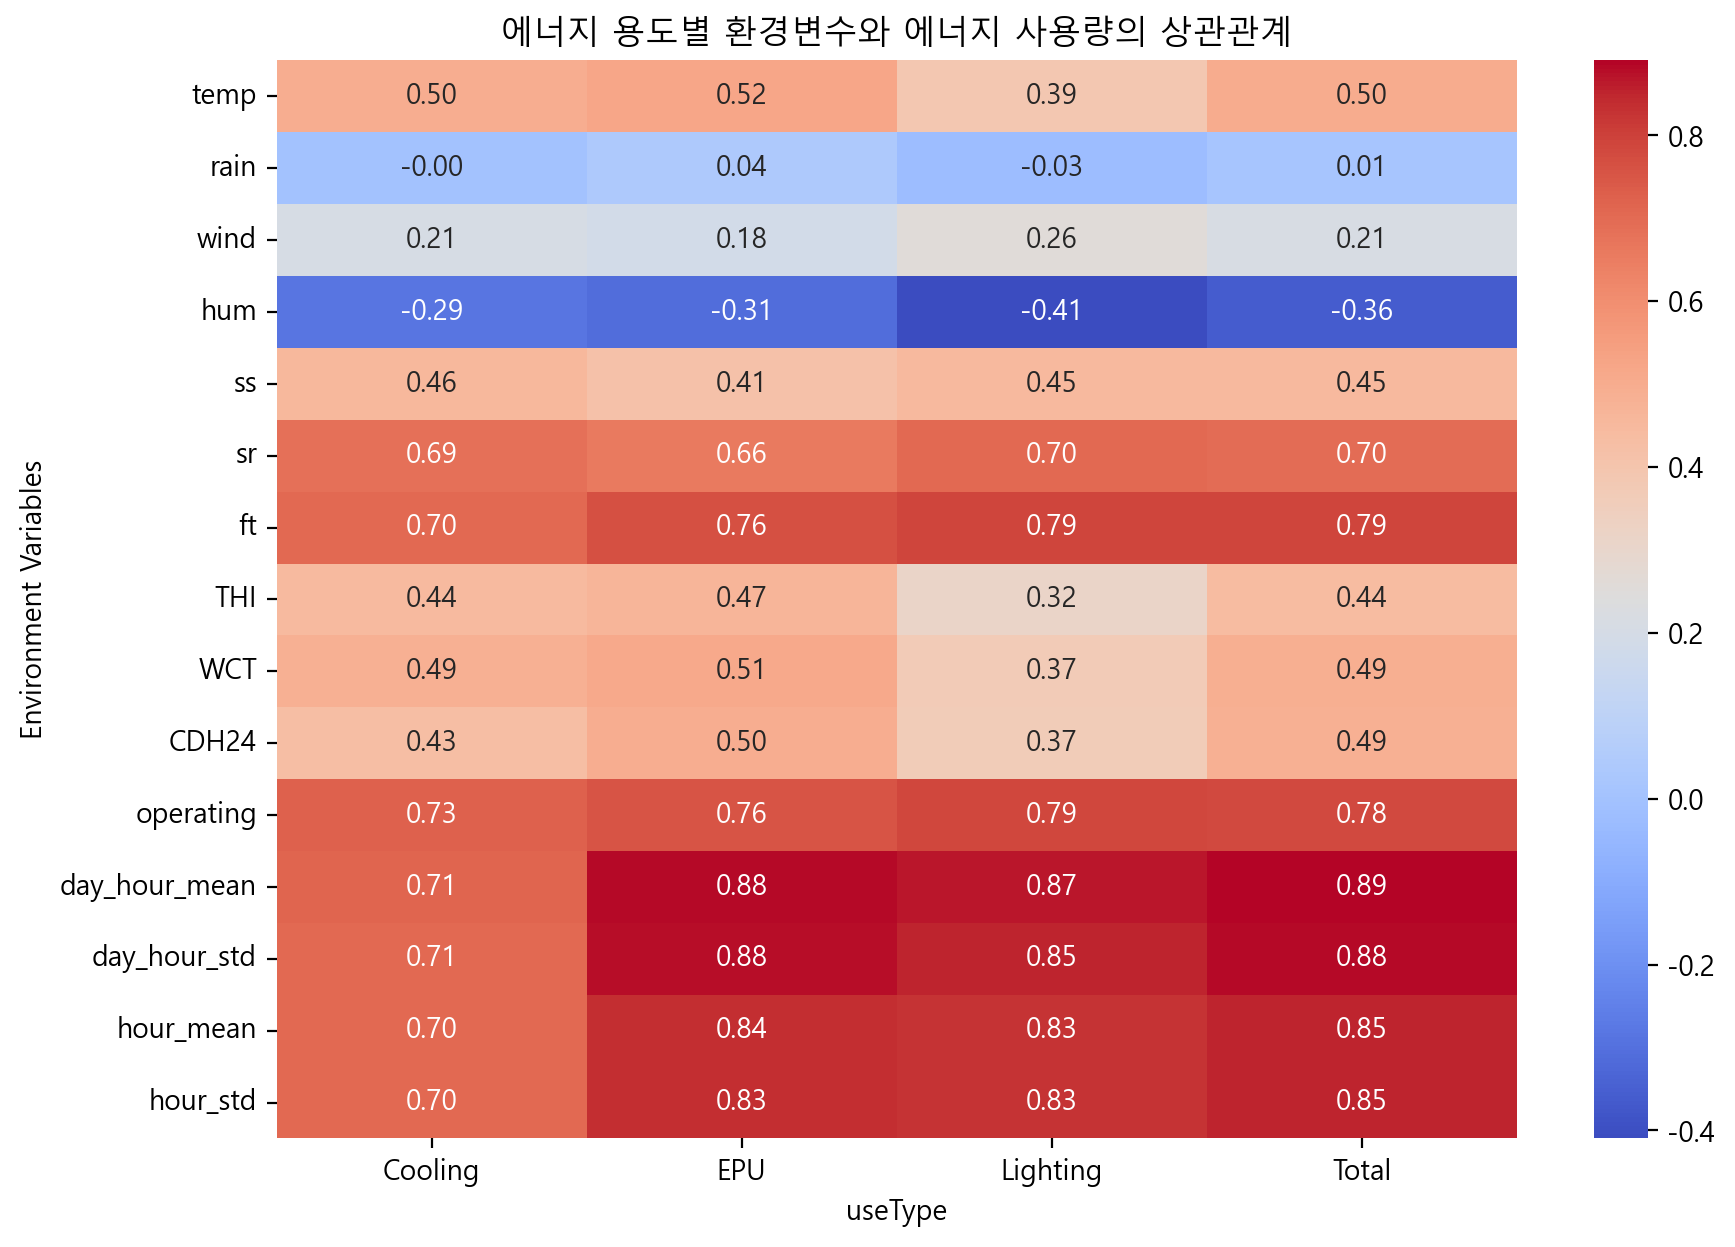

In [ ]:
corrs = []
for x in train_df.useType.unique():
    corr = []
    corr.append(x)
    for feat in ['temp', 'rain', 'wind', 'hum', 'ss', 'sr', 'ft', 'THI', 'WCT', 'CDH24','operating', 'day_hour_mean',
       'day_hour_std', 'hour_mean', 'hour_std']:
        corr.append(spearmanr(train_df.loc[train_df.useType == x, feat], train_df.loc[train_df.useType == x, 'toeQty']).correlation)
    corrs.append(corr)
    
corr_df = pd.DataFrame(np.array(corrs), columns =  ['useType', 'temp', 'rain', 'wind', 'hum', 'ss', 'sr', 'ft', 'THI', 'WCT', 'CDH24','operating', 'day_hour_mean',
       'day_hour_std', 'hour_mean', 'hour_std'])
corr_df.set_index('useType', inplace=True)
corr_df = corr_df.transpose()
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 7))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('에너지 용도별 환경변수와 에너지 사용량의 상관관계')
plt.xlabel('useType')
plt.ylabel('Environment Variables')
plt.show()

### 전체 - CV(RMSE) SCORE: 26.745063922742723

In [ ]:
xxx = 'Total'

#### train, test set 

In [ ]:
globals()['y_train_{}'.format(xxx)] = train_df[train_df.useType == f'{xxx}']['toeQty']
globals()['X_train_{}'.format(xxx)] = train_df.drop(['toeQty'], axis=1)
globals()['X_train_{}'.format(xxx)] = globals()['X_train_{}'.format(xxx)][globals()['X_train_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_train_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)

globals()['y_test_{}'.format(xxx)] = test_df[test_df.useType == f'{xxx}']['toeQty']
globals()['X_test_{}'.format(xxx)] = test_df.drop(['toeQty'], axis=1)
globals()['X_test_{}'.format(xxx)] = globals()['X_test_{}'.format(xxx)][globals()['X_test_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_test_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)
test_useDate = test_df[test_df.useType == f'{xxx}']['useDate']

#### importance

In [ ]:
# CatBoostRegressor 모델 초기화
tree_model = CatBoostRegressor(random_state=SEED, verbose=False)

# 모델을 학습 데이터로 학습
tree_model.fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

# 피처 중요도를 얻어옴
feature_importance = tree_model.get_feature_importance()

# 피처명을 가져옴
feature_names = globals()['X_train_{}'.format(xxx)].columns

# 중요도를 데이터프레임으로 변환
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# 중요도를 기준으로 내림차순 정렬
fi_df = fi_df.sort_values(by='importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'CatBoost Feature Importance : {xxx}')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 뒤집음
plt.show()


KeyError: 'X_train_'

#### ML

##### MODEL

In [ ]:
globals()['automl_{}'.format(xxx)] = AutoML(mode="Perform",
                                            algorithms=["CatBoost", "Xgboost", "LightGBM"],
                                            results_path=f"model/DV_{DV}/op_{Operating_yn}/{xxx}",
                                            eval_metric='rmse' , explain_level=0)
globals()['automl_{}'.format(xxx)].fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

AutoML directory: model/DV_Y/op_N/Total
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['CatBoost', 'Xgboost', 'LightGBM']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models
1_Default_LightGBM rmse 571.501395 trained in 15.69 seconds (1-sample predict time 0.0635 seconds)
2_Default_Xgboost rmse 635.747956 trained in 8.41 seconds (1-sample predict time 0.1125 seconds)
3_Default_CatBoost rmse 613.389199 trained in 11.51 seconds (1-sample predict time 0.0606 seconds)
* Step not_so_random will try to check up to 12 models
8_LightGBM rmse 585.977901 trained in 9.65 seconds (1-sample predict time 0.0745 seconds)
4_Xgboost rmse 548.01857 trained in 10.64 seconds (1-sam

AutoML(algorithms=['CatBoost', 'Xgboost', 'LightGBM'], eval_metric='rmse',
       explain_level=0, mode='Perform', results_path='model/DV_Y/op_N/Total')

##### CV(RMSE) SCORE

In [ ]:
globals()['pred_{}'.format(xxx)] = globals()['automl_{}'.format(xxx)].predict(globals()['X_test_{}'.format(xxx)])
print(f"CV(RMSE) SCORE: {cvrmse_score(globals()['y_test_{}'.format(xxx)], globals()['pred_{}'.format(xxx)])}")

CV(RMSE) SCORE: 24.4267768106242


##### Actual VS Predict lineplot

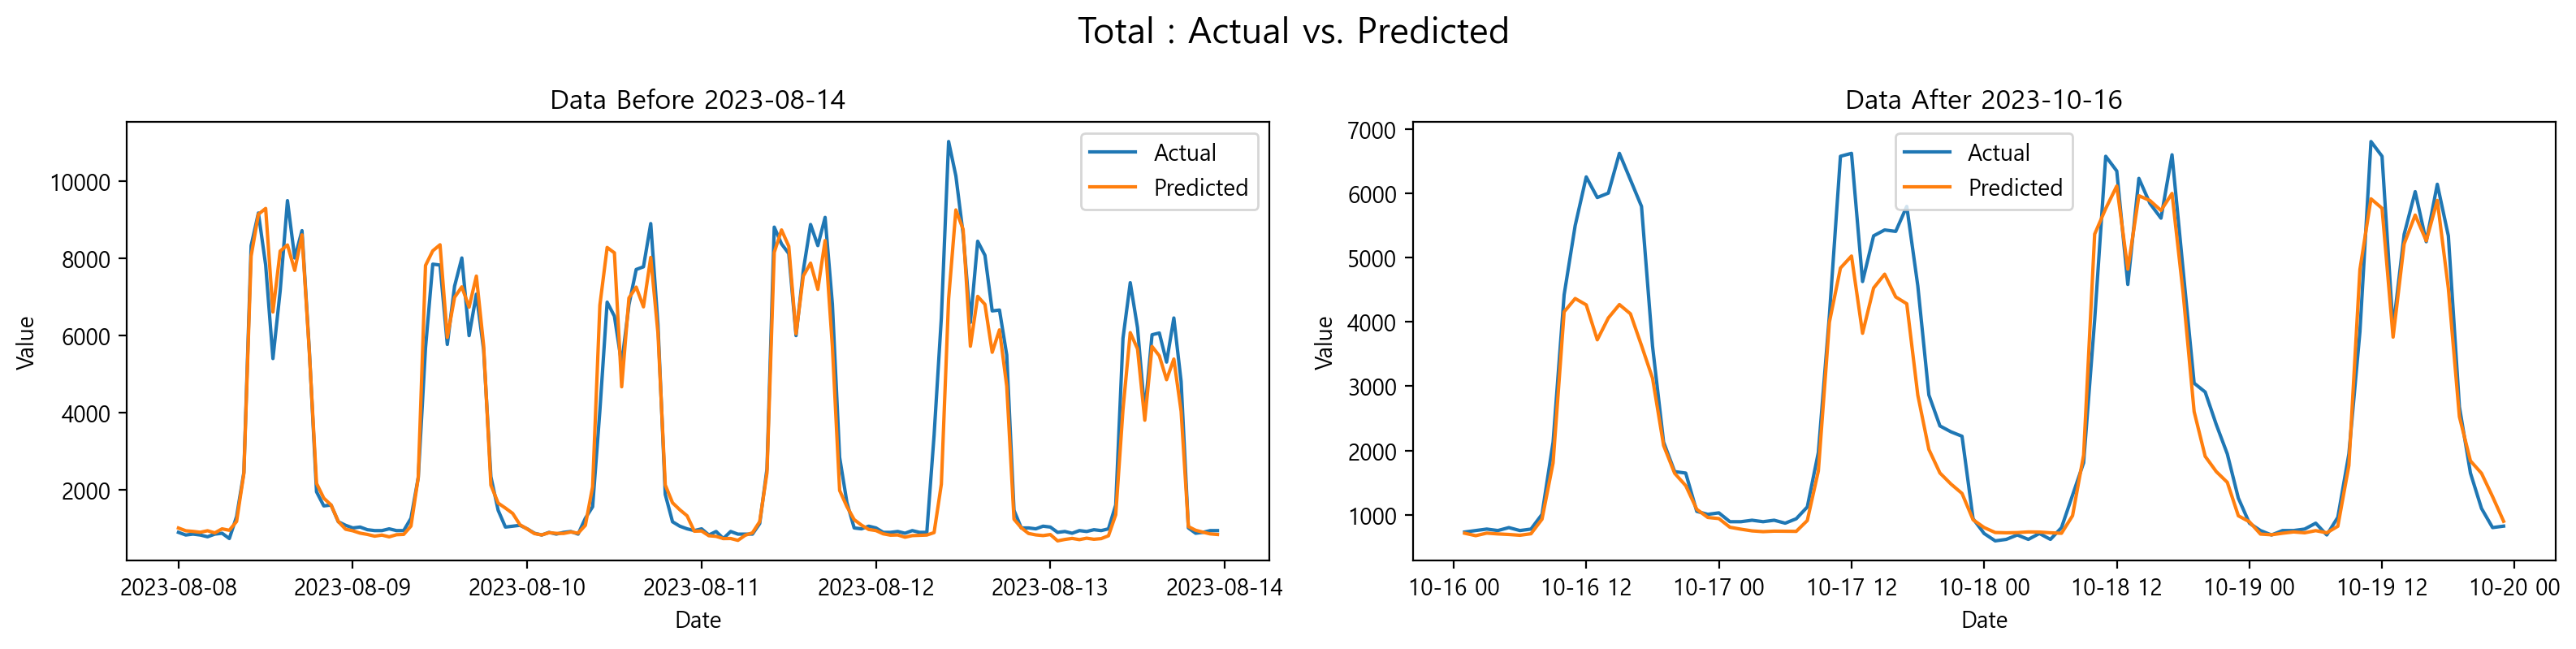

In [ ]:
result_df = pd.DataFrame({'useDate': test_useDate, '실제': globals()['y_test_{}'.format(xxx)], '예측': globals()['pred_{}'.format(xxx)]})
before_df = result_df[result_df['useDate'] < '2023-08-15']
after_df = result_df[result_df['useDate'] > '2023-10-16']

Totalfig, axes = plt.subplots(1, 2, figsize=(16 , 4))

axes[0].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[0].plot(before_df['useDate'], before_df['예측'], label='Predicted')
axes[0].set_title('Data Before 2023-08-14')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(after_df['useDate'], after_df['실제'], label='Actual')
axes[1].plot(after_df['useDate'], after_df['예측'], label='Predicted')
axes[1].set_title('Data After 2023-10-16')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

Totalfig.suptitle(f'{xxx} : Actual vs. Predicted', fontsize=16)
plt.tight_layout()
plt.show()


### 냉방 - CV(RMSE) SCORE: 75.36374241623854

In [ ]:
xxx = 'Cooling'

#### train, test set 

In [ ]:
globals()['y_train_{}'.format(xxx)] = train_df[train_df.useType == f'{xxx}']['toeQty']
globals()['X_train_{}'.format(xxx)] = train_df.drop(['toeQty'], axis=1)
globals()['X_train_{}'.format(xxx)] = globals()['X_train_{}'.format(xxx)][globals()['X_train_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_train_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)

globals()['y_test_{}'.format(xxx)] = test_df[test_df.useType == f'{xxx}']['toeQty']
globals()['X_test_{}'.format(xxx)] = test_df.drop(['toeQty'], axis=1)
globals()['X_test_{}'.format(xxx)] = globals()['X_test_{}'.format(xxx)][globals()['X_test_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_test_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)
test_useDate = test_df[test_df.useType == f'{xxx}']['useDate']

#### importance

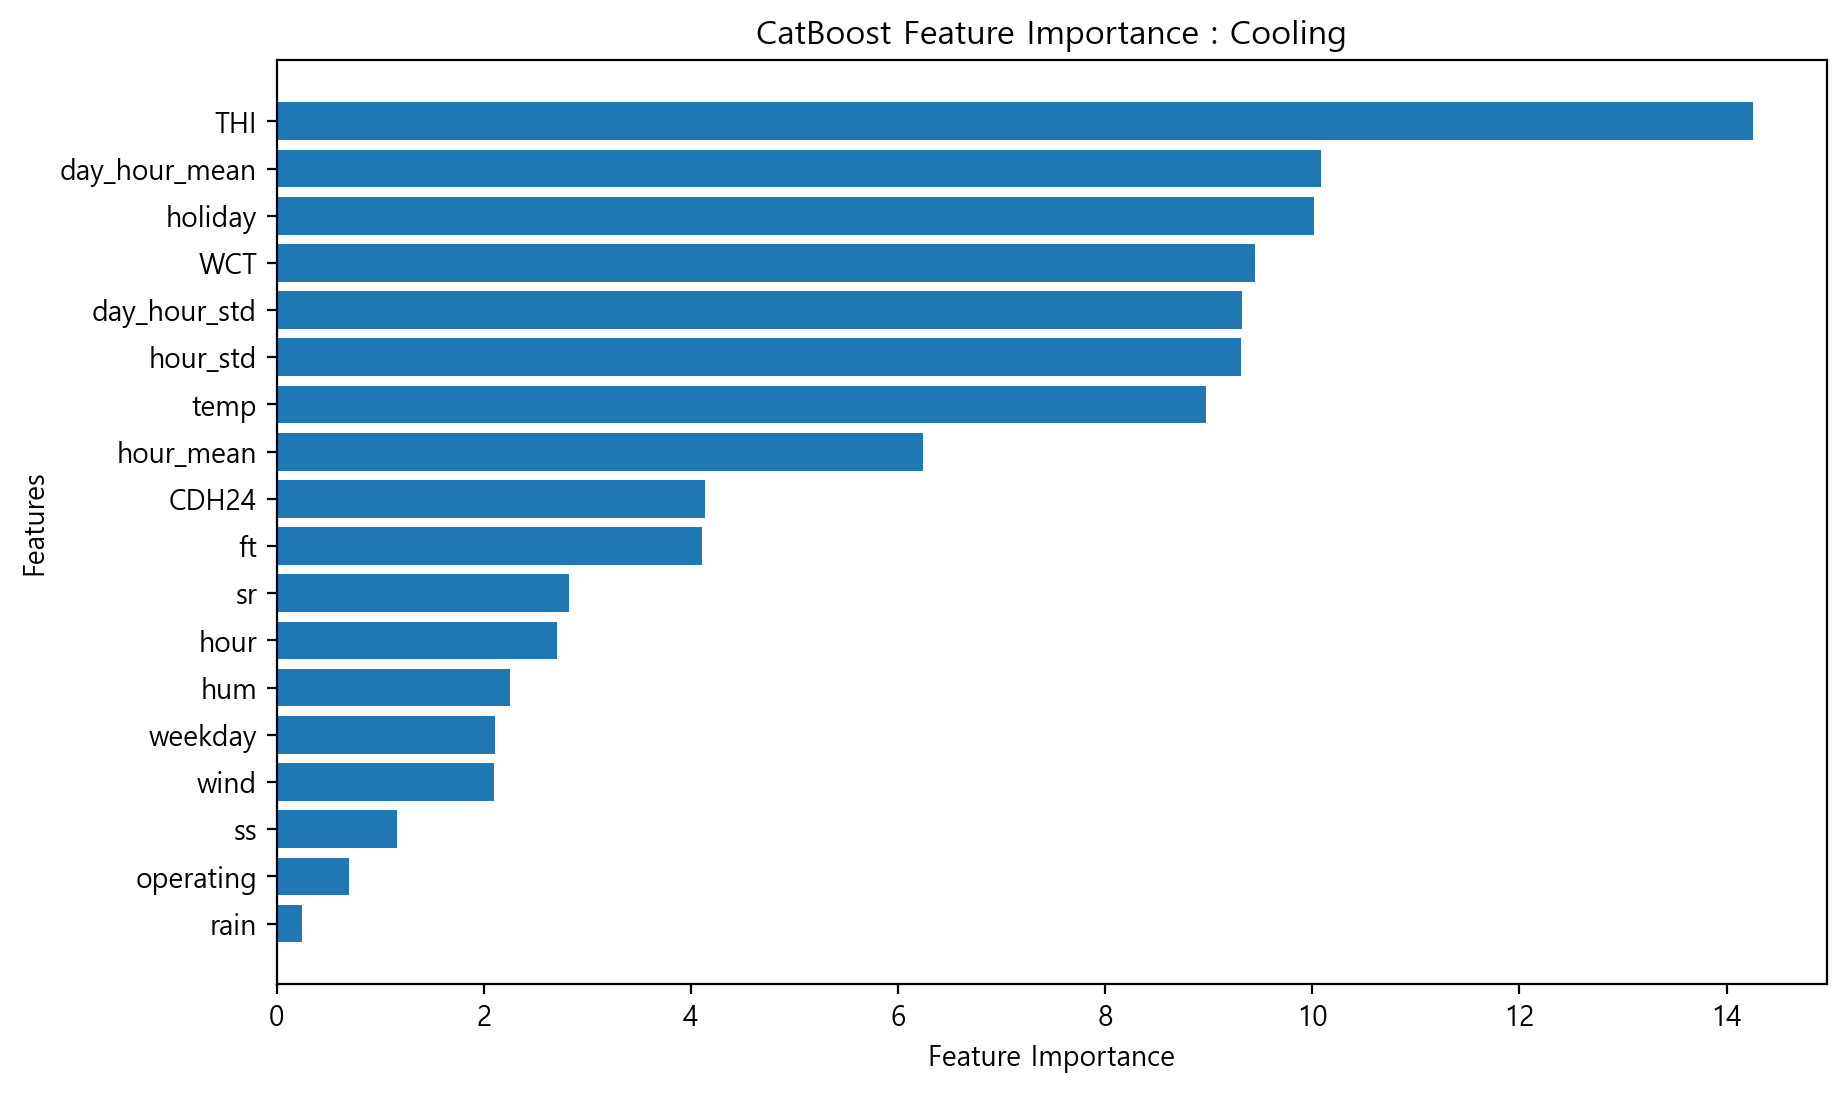

In [ ]:
# CatBoostRegressor 모델 초기화
tree_model = CatBoostRegressor(random_state=SEED, verbose=False)

# 모델을 학습 데이터로 학습
tree_model.fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

# 피처 중요도를 얻어옴
feature_importance = tree_model.get_feature_importance()

# 피처명을 가져옴
feature_names = globals()['X_train_{}'.format(xxx)].columns

# 중요도를 데이터프레임으로 변환
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# 중요도를 기준으로 내림차순 정렬
fi_df = fi_df.sort_values(by='importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'CatBoost Feature Importance : {xxx}')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 뒤집음
plt.show()


#### ML

##### MODEL

In [ ]:
globals()['automl_{}'.format(xxx)] = AutoML(mode="Perform",
                                            algorithms=["CatBoost", "Xgboost", "LightGBM"],
                                            results_path=f"model/DV_{DV}/op_{Operating_yn}/{xxx}",
                                            eval_metric='rmse' , explain_level=0)
globals()['automl_{}'.format(xxx)].fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

AutoML directory: model/DV_Y/op_N/Cooling
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['CatBoost', 'Xgboost', 'LightGBM']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models
1_Default_LightGBM rmse 276.620644 trained in 14.12 seconds (1-sample predict time 0.0765 seconds)
2_Default_Xgboost rmse 287.066558 trained in 10.84 seconds (1-sample predict time 0.0965 seconds)
3_Default_CatBoost rmse 289.979947 trained in 9.58 seconds (1-sample predict time 0.058 seconds)
* Step not_so_random will try to check up to 12 models
8_LightGBM rmse 280.198665 trained in 8.78 seconds (1-sample predict time 0.0671 seconds)
4_Xgboost rmse 287.679391 trained in 10.0 seconds (1-sa

AutoML(algorithms=['CatBoost', 'Xgboost', 'LightGBM'], eval_metric='rmse',
       explain_level=0, mode='Perform', results_path='model/DV_Y/op_N/Cooling')

##### CV(RMSE) SCORE

In [ ]:
globals()['pred_{}'.format(xxx)] = globals()['automl_{}'.format(xxx)].predict(globals()['X_test_{}'.format(xxx)])
print(f"CV(RMSE) SCORE: {cvrmse_score(globals()['y_test_{}'.format(xxx)], globals()['pred_{}'.format(xxx)])}")

CV(RMSE) SCORE: 70.09607717800554


##### Actual VS Predict lineplot

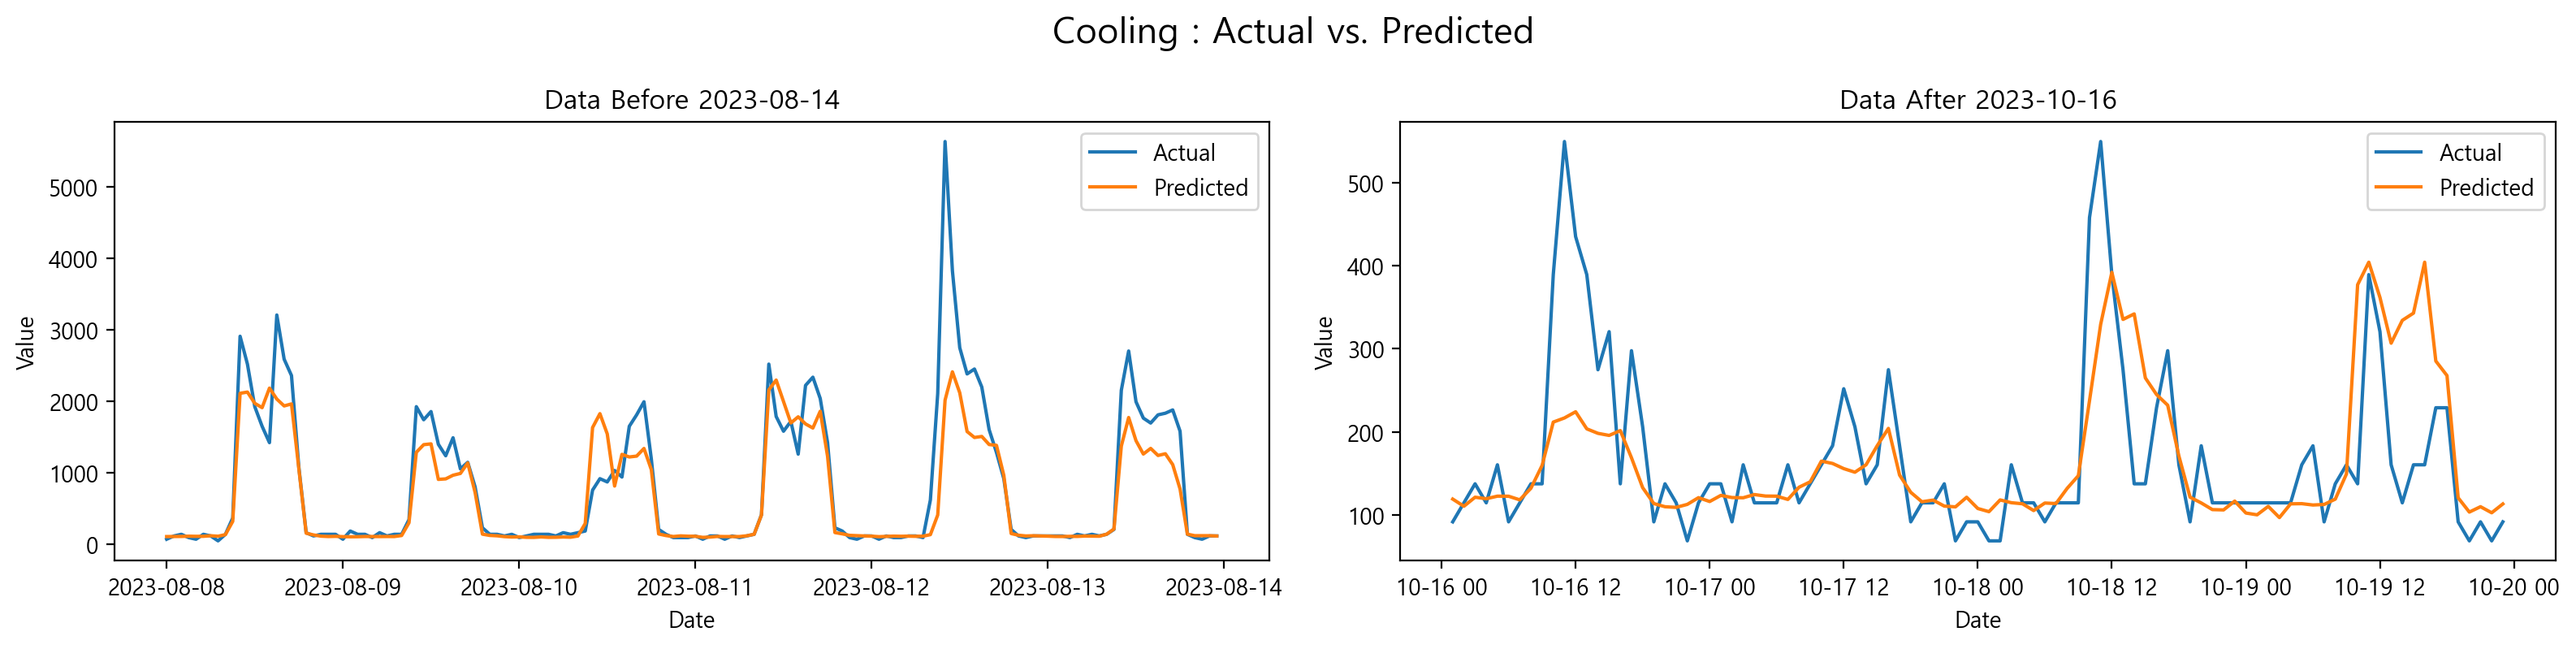

In [ ]:
result_df = pd.DataFrame({'useDate': test_useDate, '실제': globals()['y_test_{}'.format(xxx)], '예측': globals()['pred_{}'.format(xxx)]})
before_df = result_df[result_df['useDate'] < '2023-08-15']
after_df = result_df[result_df['useDate'] > '2023-10-16']

Totalfig, axes = plt.subplots(1, 2, figsize=(16 , 4))

axes[0].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[0].plot(before_df['useDate'], before_df['예측'], label='Predicted')
axes[0].set_title('Data Before 2023-08-14')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(after_df['useDate'], after_df['실제'], label='Actual')
axes[1].plot(after_df['useDate'], after_df['예측'], label='Predicted')
axes[1].set_title('Data After 2023-10-16')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

Totalfig.suptitle(f'{xxx} : Actual vs. Predicted', fontsize=16)
plt.tight_layout()
plt.show()


### 조명 - CV(RMSE) SCORE: 28.09388899780324

In [ ]:
xxx = 'Lighting'

#### train, test set 

In [ ]:
globals()['y_train_{}'.format(xxx)] = train_df[train_df.useType == f'{xxx}']['toeQty']
globals()['X_train_{}'.format(xxx)] = train_df.drop(['toeQty'], axis=1)
globals()['X_train_{}'.format(xxx)] = globals()['X_train_{}'.format(xxx)][globals()['X_train_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_train_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)

globals()['y_test_{}'.format(xxx)] = test_df[test_df.useType == f'{xxx}']['toeQty']
globals()['X_test_{}'.format(xxx)] = test_df.drop(['toeQty'], axis=1)
globals()['X_test_{}'.format(xxx)] = globals()['X_test_{}'.format(xxx)][globals()['X_test_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_test_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)
test_useDate = test_df[test_df.useType == f'{xxx}']['useDate']

#### importance

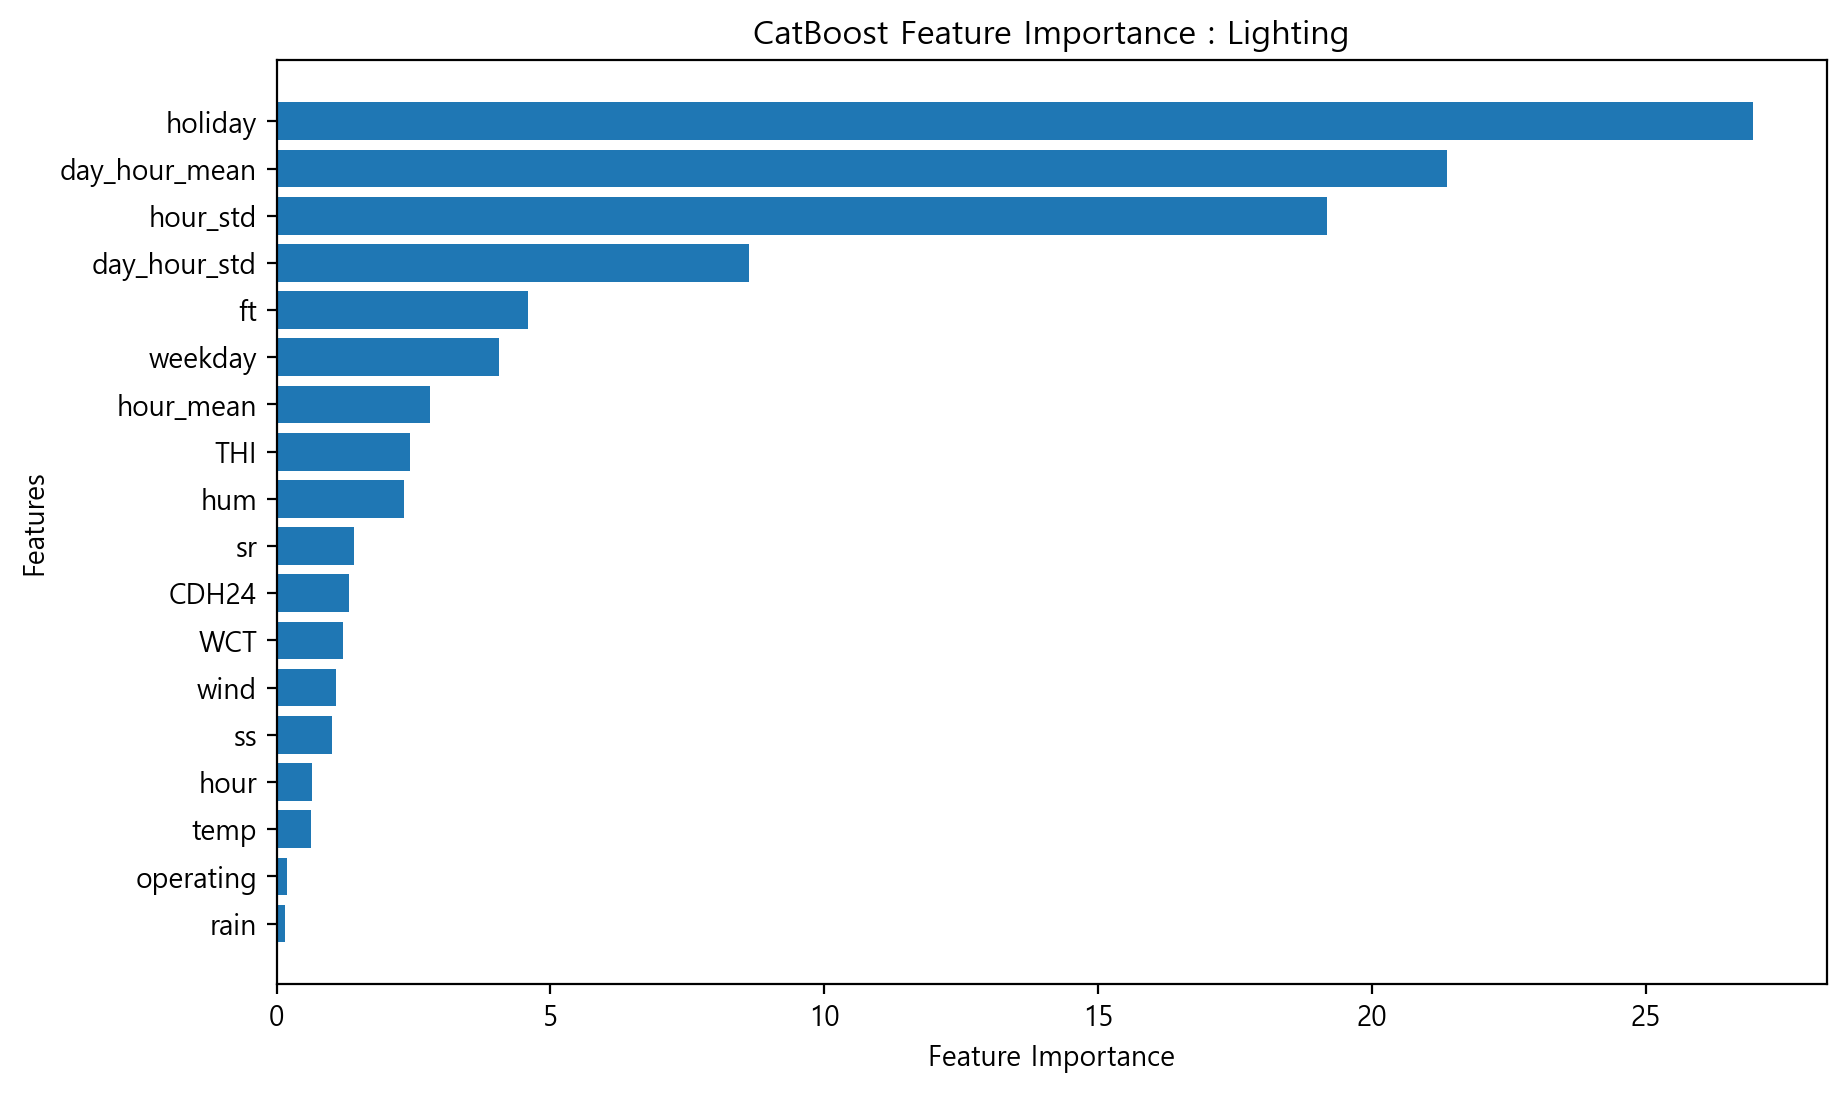

In [ ]:
# CatBoostRegressor 모델 초기화
tree_model = CatBoostRegressor(random_state=SEED, verbose=False)

# 모델을 학습 데이터로 학습
tree_model.fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

# 피처 중요도를 얻어옴
feature_importance = tree_model.get_feature_importance()

# 피처명을 가져옴
feature_names = globals()['X_train_{}'.format(xxx)].columns

# 중요도를 데이터프레임으로 변환
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# 중요도를 기준으로 내림차순 정렬
fi_df = fi_df.sort_values(by='importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'CatBoost Feature Importance : {xxx}')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 뒤집음
plt.show()


#### ML

##### MODEL

In [ ]:
globals()['automl_{}'.format(xxx)] = AutoML(mode="Perform",
                                            algorithms=["CatBoost", "Xgboost", "LightGBM"],
                                            results_path=f"model/DV_{DV}/op_{Operating_yn}/{xxx}",
                                            eval_metric='rmse' , explain_level=0)
globals()['automl_{}'.format(xxx)].fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

AutoML directory: model/DV_Y/op_N/Lighting
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['CatBoost', 'Xgboost', 'LightGBM']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models
1_Default_LightGBM rmse 207.363711 trained in 17.27 seconds (1-sample predict time 0.055 seconds)
2_Default_Xgboost rmse 213.931961 trained in 11.56 seconds (1-sample predict time 0.1788 seconds)
3_Default_CatBoost rmse 195.505372 trained in 13.9 seconds (1-sample predict time 0.0831 seconds)
* Step not_so_random will try to check up to 12 models
8_LightGBM rmse 212.230917 trained in 12.96 seconds (1-sample predict time 0.0562 seconds)
4_Xgboost rmse 206.270306 trained in 12.28 seconds (1

AutoML(algorithms=['CatBoost', 'Xgboost', 'LightGBM'], eval_metric='rmse',
       explain_level=0, mode='Perform',
       results_path='model/DV_Y/op_N/Lighting')

##### CV(RMSE) SCORE

In [ ]:
globals()['pred_{}'.format(xxx)] = globals()['automl_{}'.format(xxx)].predict(globals()['X_test_{}'.format(xxx)])
print(f"CV(RMSE) SCORE: {cvrmse_score(globals()['y_test_{}'.format(xxx)], globals()['pred_{}'.format(xxx)])}")

CV(RMSE) SCORE: 28.3743594575376


##### Actual VS Predict lineplot

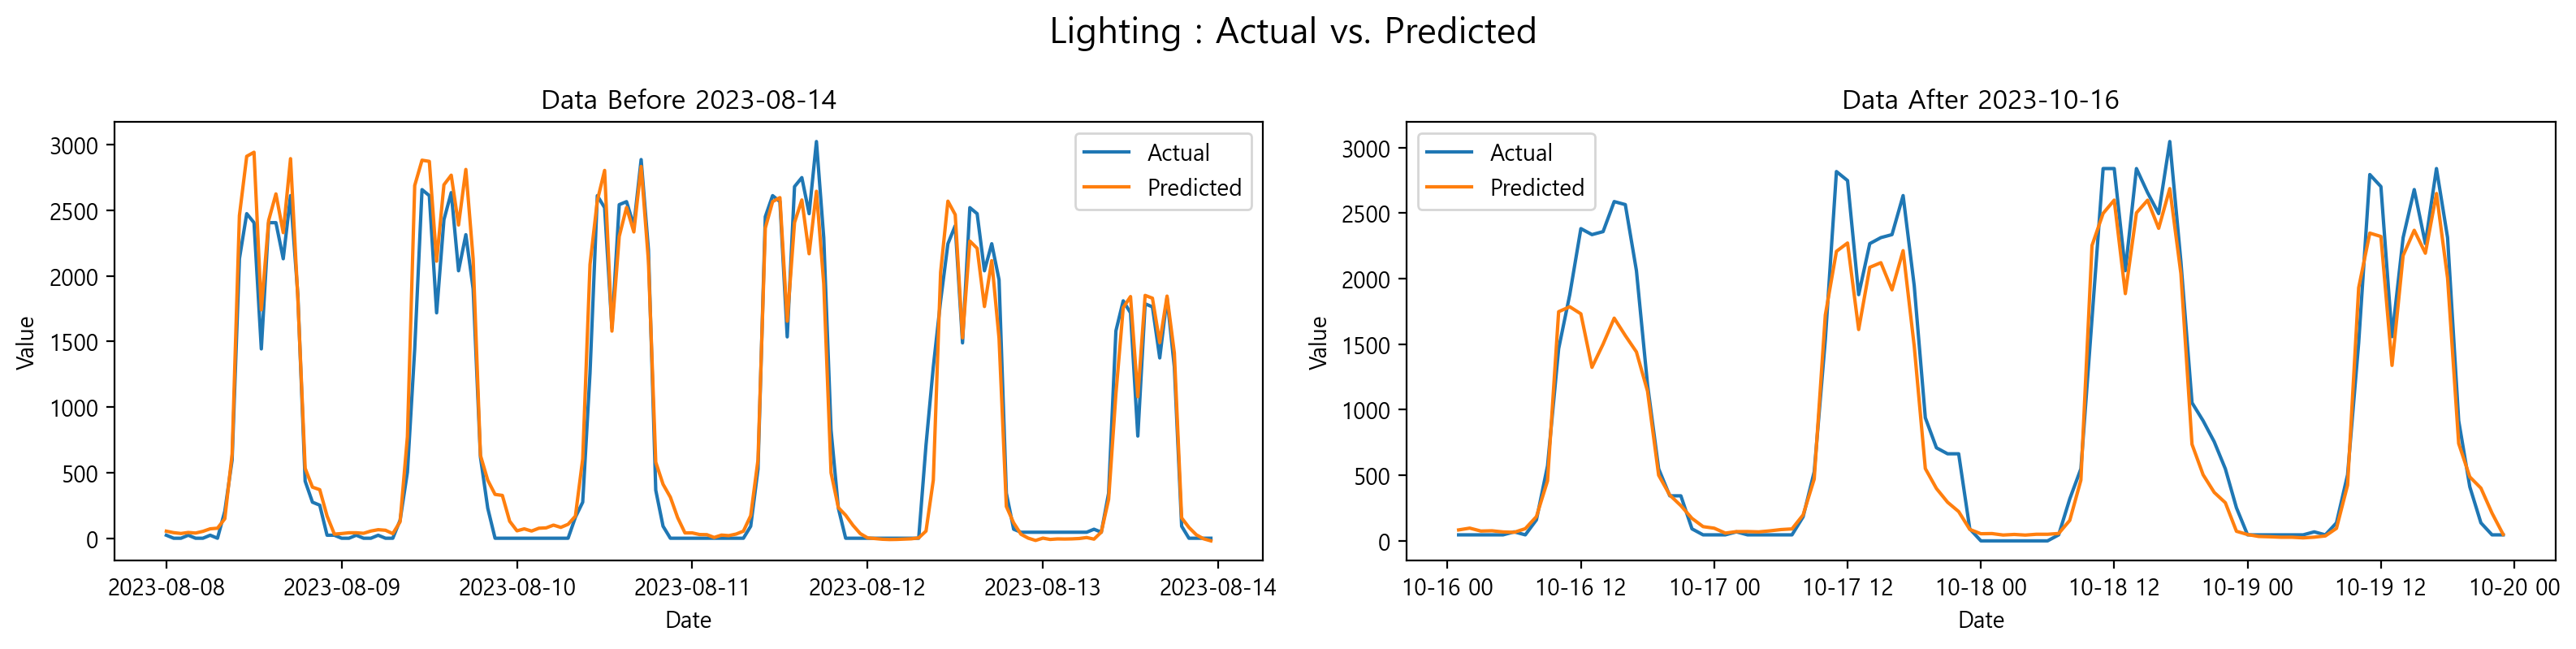

In [ ]:
result_df = pd.DataFrame({'useDate': test_useDate, '실제': globals()['y_test_{}'.format(xxx)], '예측': globals()['pred_{}'.format(xxx)]})
before_df = result_df[result_df['useDate'] < '2023-08-15']
after_df = result_df[result_df['useDate'] > '2023-10-16']

Totalfig, axes = plt.subplots(1, 2, figsize=(16 , 4))

axes[0].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[0].plot(before_df['useDate'], before_df['예측'], label='Predicted')
axes[0].set_title('Data Before 2023-08-14')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(after_df['useDate'], after_df['실제'], label='Actual')
axes[1].plot(after_df['useDate'], after_df['예측'], label='Predicted')
axes[1].set_title('Data After 2023-10-16')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

Totalfig.suptitle(f'{xxx} : Actual vs. Predicted', fontsize=16)
plt.tight_layout()
plt.show()


### 전열 - CV(RMSE) SCORE: 21.253514368461136

In [ ]:
xxx = 'EPU'

#### train, test set 

In [ ]:
globals()['y_train_{}'.format(xxx)] = train_df[train_df.useType == f'{xxx}']['toeQty']
globals()['X_train_{}'.format(xxx)] = train_df.drop(['toeQty'], axis=1)
globals()['X_train_{}'.format(xxx)] = globals()['X_train_{}'.format(xxx)][globals()['X_train_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_train_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)

globals()['y_test_{}'.format(xxx)] = test_df[test_df.useType == f'{xxx}']['toeQty']
globals()['X_test_{}'.format(xxx)] = test_df.drop(['toeQty'], axis=1)
globals()['X_test_{}'.format(xxx)] = globals()['X_test_{}'.format(xxx)][globals()['X_test_{}'.format(xxx)].useType == f'{xxx}']
globals()['X_test_{}'.format(xxx)].drop(['useType', 'useDate', 'date', 'month', 'day'], axis=1, inplace=True)
test_useDate = test_df[test_df.useType == f'{xxx}']['useDate']

#### importance

In [ ]:
# CatBoostRegressor 모델 초기화
tree_model = CatBoostRegressor(random_state=SEED, verbose=False)

# 모델을 학습 데이터로 학습
tree_model.fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

# 피처 중요도를 얻어옴
feature_importance = tree_model.get_feature_importance()

# 피처명을 가져옴
feature_names = globals()['X_train_{}'.format(xxx)].columns

# 중요도를 데이터프레임으로 변환
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# 중요도를 기준으로 내림차순 정렬
fi_df = fi_df.sort_values(by='importance', ascending=False)

# 중요도를 시각화
plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'CatBoost Feature Importance : {xxx}')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위로 오도록 뒤집음
plt.show()


KeyError: 'X_train_'

#### ML

##### MODEL

In [ ]:
globals()['automl_{}'.format(xxx)] = AutoML(mode="Perform",
                                            algorithms=["CatBoost", "Xgboost", "LightGBM"],
                                            results_path=f"model/DV_{DV}/op_{Operating_yn}/{xxx}",
                                            eval_metric='rmse' , explain_level=0)
globals()['automl_{}'.format(xxx)].fit(globals()['X_train_{}'.format(xxx)], globals()['y_train_{}'.format(xxx)])

AutoML directory: model/DV_Y/op_N/EPU
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['CatBoost', 'Xgboost', 'LightGBM']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models
1_Default_LightGBM rmse 247.697237 trained in 18.91 seconds (1-sample predict time 0.0805 seconds)
2_Default_Xgboost rmse 255.905746 trained in 15.26 seconds (1-sample predict time 0.096 seconds)
3_Default_CatBoost rmse 252.70617 trained in 17.22 seconds (1-sample predict time 0.0717 seconds)
* Step not_so_random will try to check up to 12 models
8_LightGBM rmse 255.881612 trained in 13.17 seconds (1-sample predict time 0.0585 seconds)
4_Xgboost rmse 238.970306 trained in 15.23 seconds (1-samp

AutoML(algorithms=['CatBoost', 'Xgboost', 'LightGBM'], eval_metric='rmse',
       explain_level=0, mode='Perform', results_path='model/DV_Y/op_N/EPU')

##### CV(RMSE) SCORE

In [ ]:
globals()['pred_{}'.format(xxx)] = globals()['automl_{}'.format(xxx)].predict(globals()['X_test_{}'.format(xxx)])
print(f"CV(RMSE) SCORE: {cvrmse_score(globals()['y_test_{}'.format(xxx)], globals()['pred_{}'.format(xxx)])}")

CV(RMSE) SCORE: 20.82407113991549


##### Actual VS Predict lineplot

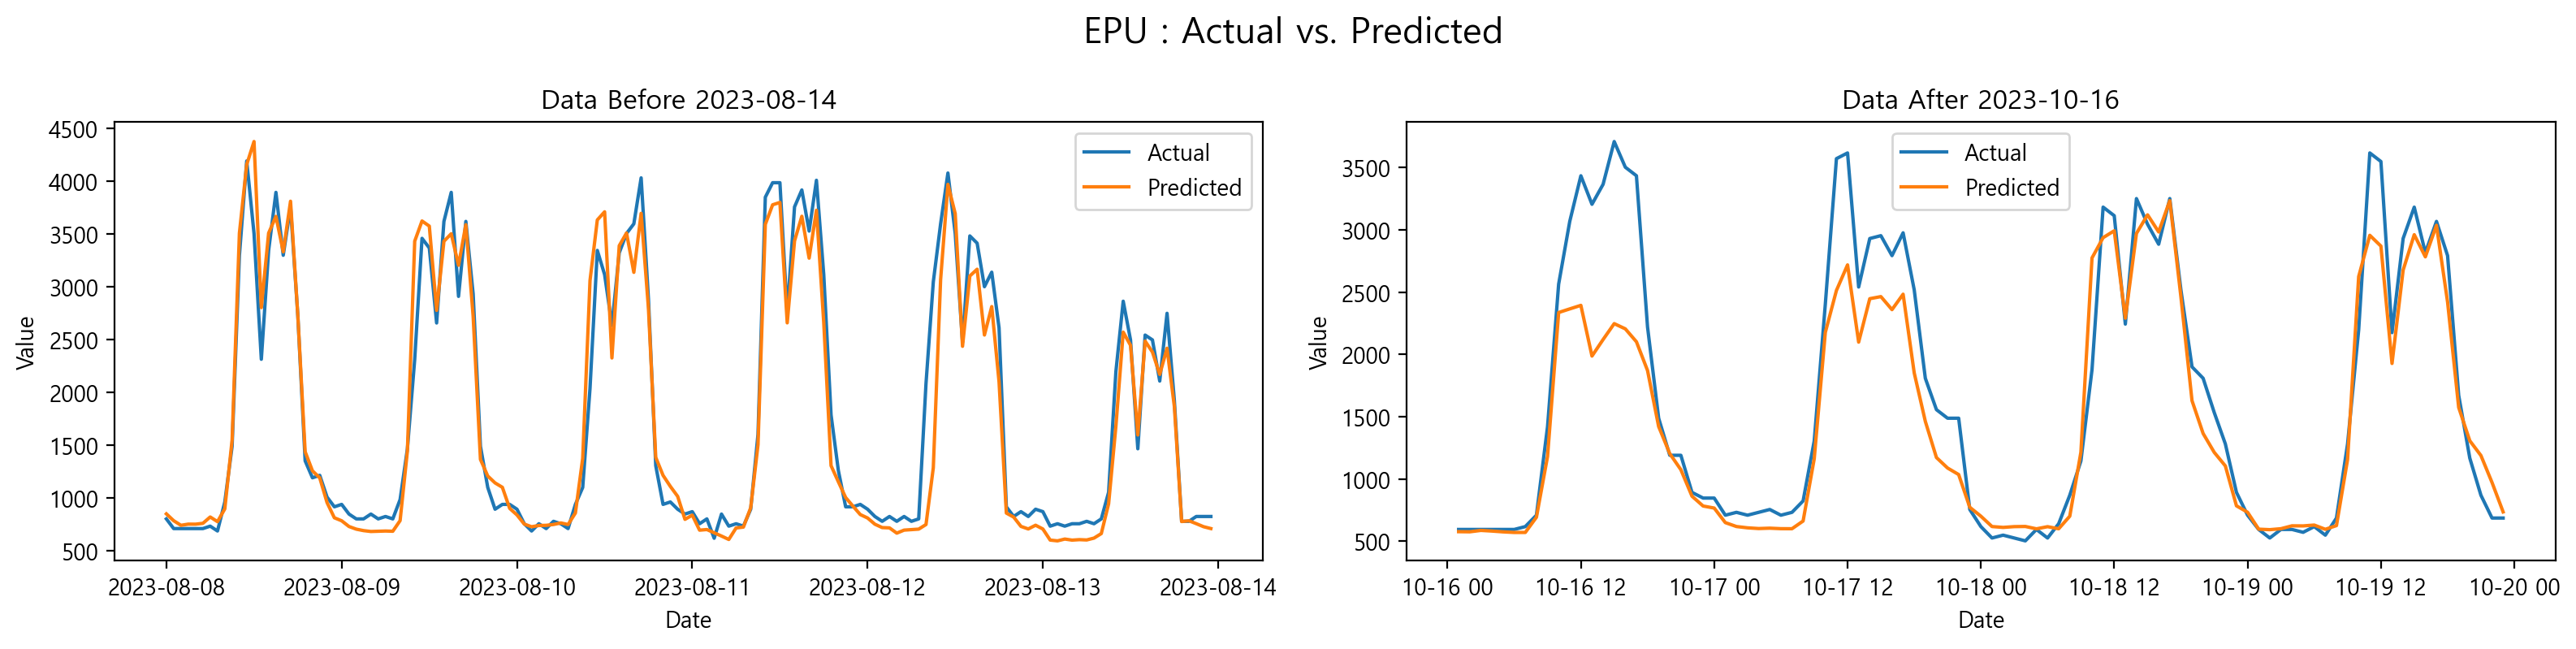

In [ ]:
result_df = pd.DataFrame({'useDate': test_useDate, '실제': globals()['y_test_{}'.format(xxx)], '예측': globals()['pred_{}'.format(xxx)]})
before_df = result_df[result_df['useDate'] < '2023-08-15']
after_df = result_df[result_df['useDate'] > '2023-10-16']

Totalfig, axes = plt.subplots(1, 2, figsize=(16 , 4))

axes[0].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[0].plot(before_df['useDate'], before_df['예측'], label='Predicted')
axes[0].set_title('Data Before 2023-08-14')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(after_df['useDate'], after_df['실제'], label='Actual')
axes[1].plot(after_df['useDate'], after_df['예측'], label='Predicted')
axes[1].set_title('Data After 2023-10-16')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

Totalfig.suptitle(f'{xxx} : Actual vs. Predicted', fontsize=16)
plt.tight_layout()
plt.show()


### sum(useType) vs Total - CV(RMSE) SCORE: 25.598869180428796

In [ ]:
xxx = ''

In [ ]:
globals()['y_test_{}'.format(xxx)] = test_df[test_df.useType == 'Total']['toeQty']
pred_sum = pred_Cooling + pred_Lighting + pred_EPU
print(f"CV(RMSE) SCORE: {cvrmse_score(globals()['y_test_{}'.format(xxx)], pred_sum)}")

CV(RMSE) SCORE: 24.031282431446797


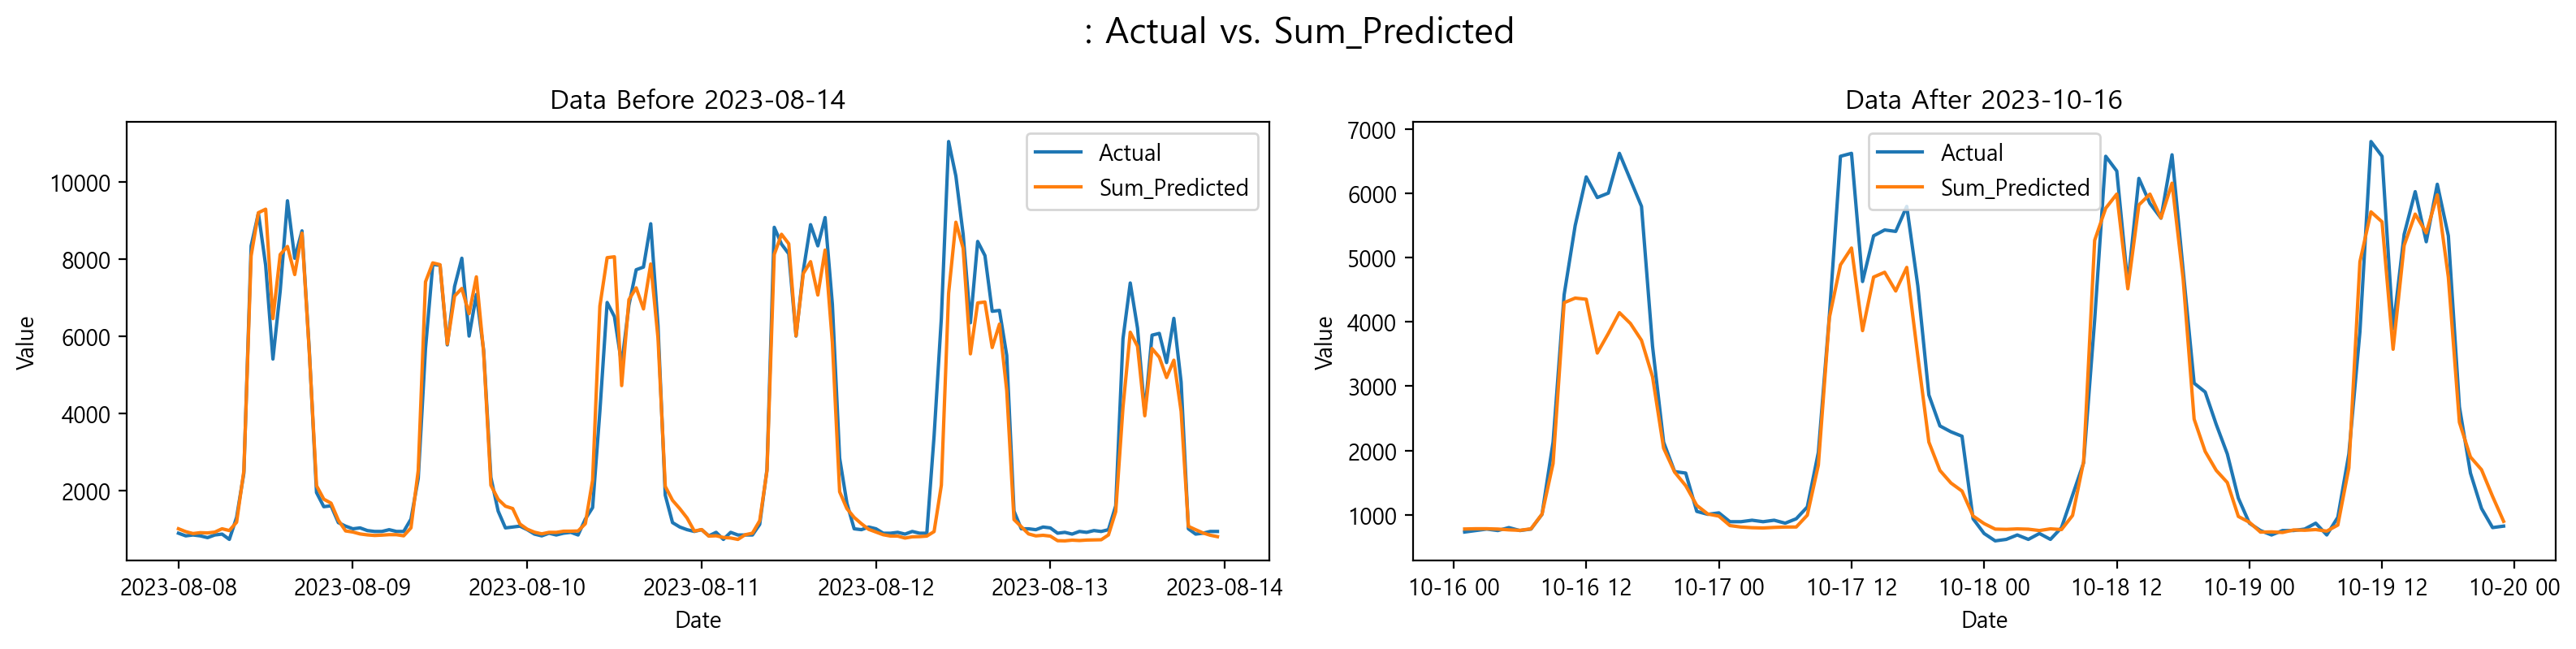

In [ ]:
result_df = pd.DataFrame({'useDate': test_useDate.reset_index(drop=True), '실제': y_test_Total.reset_index(drop=True), '부분모델_예측': pred_sum, '통모델_예측' : pred_Total})
before_df = result_df[result_df['useDate'] < '2023-08-15']
after_df = result_df[result_df['useDate'] > '2023-10-16']

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(before_df['useDate'], before_df['실제'], label='Actual')
axes[0].plot(before_df['useDate'], before_df['부분모델_예측'], label='Sum_Predicted')
# axes[0].plot(before_df['useDate'], before_df['통모델_예측'], label='Total_Predicted')
axes[0].set_title('Data Before 2023-08-14')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(after_df['useDate'], after_df['실제'], label='Actual')
axes[1].plot(after_df['useDate'], after_df['부분모델_예측'], label='Sum_Predicted')
# axes[1].plot(before_df['useDate'], before_df['통모델_예측'], label='Total_Predicted')
axes[1].set_title('Data After 2023-10-16')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()

fig.suptitle(f'{xxx} : Actual vs. Sum_Predicted', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
result_df.to_csv(f'data/result/DV_{DV}_op_{Operating_yn}.csv', index=False)